# Commons

In [1]:
# Data processing 
import numpy as np
import pandas as pd

# Data visualisation
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Commons
import gc
import os
import math
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

In [2]:
ARTICLES_CSV_PATH      = '../input/h-and-m-personalized-fashion-recommendations/articles.csv'
CUSTOMERS_CSV_PATH     = '../input/h-and-m-personalized-fashion-recommendations/customers.csv'
TRANSACTIONS_CSV_PATH  = '../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
SAMPLE_SUBMISSION_PATH = '../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'
ARTICLES_IMAGES_PATH   = '../input/h-and-m-personalized-fashion-recommendations/images/'

In [3]:
def stop_execution():
    """ 
    Stop the execution of the program
    """
    raise SystemExit()

    
def is_kaggle_gpu_enabled():
    """
    Return whether GPU is enabled in the running Kaggle kernel
    """
    
    import tensorflow as tf
    return len(tf.config.list_physical_devices('GPU')) > 0


def csv_to_df(csv_path, cudf=False):
    """ 
    Convert a `csv` file to `pd/cudf Dataframe`
    If the given file path is not correct, then `None` is returned
    
    @param csv_path: Path to the csv file
    @return: Parsed csv file or `None`
    @rtype: pd/cudf.Dataframe    
    """
    
    if not os.path.isfile(csv_path):
        print(f"The file '{csv_path}' doesn't exist!")
        return None
    
    if cudf == True:
        return cudf.read_csv(csv_path)
    return pd.read_csv(csv_path)


def group_data_by(data, groupby, countby):
    """
    Group data based on the column `groupby`
    and count values by after the `countby` param
    
    @param data: Dataframe to be grouped
    @param groupby: Key used to group the data
    @param countby: Count the instances based on this key
    @return: df with 2 columns: `groupby` and `count`
    @rtype: Dataframe
    """
    
    # Check if the param `groupby` is a nested list 
    if not any(isinstance(x, list) for x in groupby):
        group_by = groupby
    else:
        group_by = [groupby]
    
    grouped_data = data                  \
        .groupby(group_by)               \
        .count()[countby]                \
        .sort_values(ascending=False)    \
        .reset_index()
    return grouped_data.rename(columns={countby: 'count'})

In [4]:
# Check if Kaggle GPU's kernel is enabled
if not is_kaggle_gpu_enabled():
    print('Enable Kaggle GPU before running this notebook!')
    stop_execution()

2022-03-29 07:47:51.669390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 07:47:51.749440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 07:47:51.750124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# In will use `RAPIDS cuDF` instead of `pd df`
# for faster dataframe manipulations (requires GPU)
import cudf

# 1. Recommend using only dataframe manipulations

In [6]:
# For this approach, I will try to implement a recommendation system
# using only the existing dataframes, without involving a ML algorithm

# 1. I will recommend items previously purchased by the current `customer_id`
# 2. Then, items that are bought together with previous purchases
# 3. At the end, we can also recommend popular items

## Load the data

In [7]:
articles     = cudf.DataFrame.from_pandas(csv_to_df(ARTICLES_CSV_PATH))
customers    = cudf.DataFrame.from_pandas(csv_to_df(CUSTOMERS_CSV_PATH))
transactions = cudf.DataFrame.from_pandas(csv_to_df(TRANSACTIONS_CSV_PATH))

# Sanity check
if any(df is None for df in [articles,
                             customers,
                             transactions]):
    stop_execution()

## Reduce some memory

In [8]:
# Make a deep copy of the `transactions` df
train = cudf.DataFrame(transactions)
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [9]:
train.shape

(31788324, 5)

In [10]:
# I will use this 'trick' to reduce the memory
# Here are all the explanations why I've used that's kind of mapping
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635

# Reduce `customer_id` size (64bytes -> 8bytes)
train['customer_id'] = train['customer_id'] \
    .str[-16:]                              \
    .str.hex_to_int()                       \
    .astype('int64')                        \

# Reduce `article_id` size (10bytes -> 4bytes)
train['article_id'] = train['article_id'].astype('int32')

# Convert `t_dat` to `cudf datetime`
train['t_dat'] = cudf.to_datetime(train['t_dat'])

In [11]:
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,-6846340800584936,663713001,0.050831,2
1,2018-09-20,-6846340800584936,541518023,0.030492,2
2,2018-09-20,-8334631767138808638,505221004,0.015237,2
3,2018-09-20,-8334631767138808638,685687003,0.016932,2
4,2018-09-20,-8334631767138808638,685687004,0.016932,2


In [12]:
# Save this version of `train reduced memory`
# V1) Make a deep copy of the current df and store it in the RAM memory,
# which is not a good idea: train_mem_red = cudf.DataFrame(train)
# V2) Save it to a file and load when needed (lazy initialization)
train.to_parquet('train.pqt')

## (i) Recommend previously purchased items

In [13]:
# For this, we will only need the columns `t_dat`, `customer_id` and `article_id`
# So, we can drop the `price` and `sales_channel_id` attributes
train.drop(columns=['price', 'sales_channel_id'], inplace=True)
train.head(1)

,t_dat,customer_id,article_id
0,2018-09-20,-6846340800584936,663713001


In [14]:
# For each customer, compute the last date of purchases, individually
train_grouped_customer_id = train.groupby('customer_id')
train_last_purchase = train_grouped_customer_id['t_dat'].max()
train_last_purchase = train_last_purchase.reset_index()
train_last_purchase = train_last_purchase.rename(columns={'t_dat': 'max_dat'})
train_last_purchase.head()

,customer_id,max_dat
0,-5930446966655949845,2020-03-25
1,6138898004712415003,2020-07-28
2,-3758009466528006904,2019-04-15
3,-4320000672183660287,2019-12-03
4,-4194961289286638255,2020-04-20


In [15]:
# Let's now merge the `max_dat` column to the `train` df
train = train.merge(train_last_purchase, on=['customer_id'], how='left')
train.head()

,t_dat,customer_id,article_id,max_dat
0,2018-09-21,-4745167340148134637,637194001,2020-07-11
1,2018-09-21,-4745167340148134637,627147001,2020-07-11
2,2018-09-21,-4745167340148134637,627147002,2020-07-11
3,2018-09-21,-4745167340148134637,464454011,2020-07-11
4,2018-09-21,-4745167340148134637,637194001,2020-07-11


In [16]:
# Delete unused objects
del train_grouped_customer_id
del train_last_purchase
gc.collect()

72

In [17]:
# We can now compute the difference between the `max_dat` and `t_dat`
# In other words, calculate last_purchase_date - curr_purchase_date, for each customer's transaction
train['diff_dat'] = train['max_dat'] - train['t_dat']

# Convert to days
train['diff_dat'] = train['diff_dat'].dt.days

# Now, select purchases within the last 2 weeks 
train = train.loc[train['diff_dat'] <= 14]

In [18]:
train.head()

,t_dat,customer_id,article_id,max_dat,diff_dat
288,2018-09-20,1724137143448920012,653337002,2018-09-20,0
289,2018-09-20,1724137143448920012,650799002,2018-09-20,0
290,2018-09-20,1724137143448920012,575074001,2018-09-20,0
291,2018-09-20,1724137143448920012,553488008,2018-09-20,0
292,2018-09-20,1724137143448920012,673806003,2018-09-20,0


In [19]:
# ~5.6mil customers who bought articles in the last 2 weeks
train.shape

(5672883, 5)

In [20]:
# Group data by `customer_id` and `article_id` and count by `t_dat`
train_grouped = group_data_by(data=train,
                              groupby=['customer_id', 'article_id'],
                              countby='t_dat')
train_grouped.head()

,customer_id,article_id,count
0,2729025827381139556,719348003,100
1,4485518665254175540,557247001,86
2,-906958334866810496,852521001,81
3,-4601407992705575197,695545001,80
4,3601599666106972342,685813001,80


In [21]:
# Merge `train_grouped` and `train`
# Sort in descending order by `count` and then by `t_dat`
train = train.merge(train_grouped, on=['customer_id', 'article_id'], how='left')
train = train.drop_duplicates(['customer_id', 'article_id'])
train = train.sort_values(['count','t_dat'], ascending=False)

In [22]:
train.head()

,t_dat,customer_id,article_id,max_dat,diff_dat,count
1198496,2019-07-16,2729025827381139556,719348003,2019-07-16,0,100
62529,2018-10-04,4485518665254175540,557247001,2018-10-04,0,86
2237863,2020-03-04,-906958334866810496,852521001,2020-03-06,2,81
3646432,2020-07-06,3601599666106972342,685813001,2020-07-06,0,80
873824,2019-05-14,-4601407992705575197,695545001,2019-05-14,0,80


In [23]:
train.shape

(4986109, 6)

## (ii) Recommend items that are bought together with previous purchases

In [24]:
# This function is inspired from:
# https://www.kaggle.com/code/cdeotte/customers-who-bought-this-frequently-buy-this/notebook#Find-Items-Purchased-Together
def dict_items_freq(data):
    """
    Generate a dictionary of type {itemX: [items_bought_together_with_itemX]}
    List of recommended itemes has length maximum of 3
    
    @param `data`: Dataframe with 2 mandatory columns: `customer_id` `article_id`
    @return: Computed dictionary of 'pairs'
    """
    
    # Compute a df with the best-selling articles in descending order
    best_selling = data['article_id'].value_counts()
    
    # Create a dictionary with the following `signature`: item -> [bought_together_items]
    pairs = {}
    for _, i in enumerate(best_selling.index.values[1000:1032]):
        # Select the users who bought the current `item`
        users = data.loc[data['article_id'] == i.item(), 'customer_id'].unique()
        
        # Compute a df with the most similar articles with the current `item` (excluding itself)
        best_selling_similars = data.loc[(data['customer_id'].isin(users)) &             \
                                        (data['article_id'] != i.item()), 'article_id']  \
                                     .value_counts()
        
        # Assign a list of 3 `bought_together_items` to the current `item`
        pairs[i.item()] = [best_selling_similars.index[0],
                           best_selling_similars.index[1],
                           best_selling_similars.index[2]]
    return pairs

In [25]:
# Generate the dictionary of items frequently purchased together
pairs = dict_items_freq(train)

In [26]:
# Convert from `cudf` to `pandas` for `mapping` each item to another 3 `bought together` items
train = train.to_pandas()
# Create a new column from dictionary (map each item to a new column)
train['article_id_aux'] = train['article_id'].map(pairs)

In [27]:
# Create a df with the following columns: `customer_id` -> [`recommend_3_bought_together_items`]
train_aux = train[['customer_id', 'article_id_aux']].copy()
train_aux = train_aux.rename({'article_id_aux': 'article_id'}, axis=1)
train_aux = train_aux.loc[train_aux['article_id'].notnull()]
train_aux = train_aux.drop_duplicates(['customer_id'])

In [28]:
train_aux.head()

,customer_id,article_id
1030528,4384871127594519996,"[610776033, 610776040, 610776002]"
797323,-7026014085675726567,"[695632001, 697054003, 697054060]"
1857091,5334958048339471082,"[612481001, 612481004, 457722001]"
1078176,1084947564514430383,"[610776033, 610776040, 610776002]"
4002466,-2145655891269908529,"[717490070, 717490010, 717490008]"


In [29]:
train_aux.shape

(19018, 2)

In [30]:
# Keep only the `customer_id` and `article_id` columns
train = train[['customer_id','article_id']]
# Concatenate the `train` and `train_aux` on rows 
train = pd.concat([train, train_aux], axis=0, ignore_index=True)

In [31]:
train.head()

,customer_id,article_id
0,2729025827381139556,719348003
1,4485518665254175540,557247001
2,-906958334866810496,852521001
3,3601599666106972342,685813001
4,-4601407992705575197,695545001


In [32]:
train.shape

(5005127, 2)

In [33]:
# Delete unused objects
del train_aux
gc.collect()

42

In [34]:
# Convert recommendations into a single string
train['article_id'] = ' 0' + train['article_id'].astype('str')
predictions = cudf.DataFrame(train                            \
                       .groupby('customer_id')['article_id']  \
                       .sum()                                 \
                       .reset_index())
predictions.rename(columns={'article_id': 'prediction'}, inplace=True)

In [35]:
predictions.head()

,customer_id,prediction
0,-9223352921020755230,0673396002 0812167004
1,-9223343869995384291,0908292002 0910601003 0865929007 0903926002
2,-9223321797620987725,0580600006 0610776035
3,-9223319430705797669,0470985003 0504155001 0554477005 0562245001 0...
4,-9223308614576639426,0750423005


## (iii) Recommend last 2 weeks popular items

In [36]:
# Customizable variables
last_n_days = 14
top_n_popular_items = 10

# Open the `reduced memory train df`
train = cudf.read_parquet('train.pqt')

# Convert `t_dat` field to `cudf datetime`
# Serialization doesn't keep the `datetime` format
train['t_dat'] = cudf.to_datetime(train['t_dat'])

# Keep only the `last_n_days` entries
train = train.loc[train['t_dat'] >= cudf.to_datetime(train['t_dat'].max() - np.timedelta64(last_n_days, 'D'))]

# Compute the `top_n_popular_items` popular items within the`last_n_days`
top = ' 0' + ' 0'.join(train['article_id'].value_counts().to_pandas().index.astype('str')[:top_n_popular_items])
print(f'Top {top_n_popular_items} popular items within the last {last_n_days} days:')
print(top)

Top 10 popular items within the last 14 days:
 0909370001 0924243001 0918522001 0865799006 0751471001 0448509014 0762846027 0918292001 0923758001 0924243002


## Generate submission file

In [37]:
# Open the `submission_sample` df
submission = cudf.read_csv(SAMPLE_SUBMISSION_PATH)
submission = submission[['customer_id']]

# Reduce `customer_id` size (64bytes -> 8bytes)
submission['customer_id_aux'] = submission['customer_id'] \
                                .str[-16:]                \
                                .str.hex_to_int()         \
                                .astype('int64')

# Rename `customer_id` to `customer_id_aux` for being able to merge them
predictions.rename({'customer_id': 'customer_id_aux'}, axis=1, inplace=True)

# Merge the `submission` df with the `predictions` df,
# filling the missing values with the empty string
submission = submission.merge(predictions, on='customer_id_aux', how='left').fillna('')

# Remove the `customer_id_aux` column
del submission['customer_id_aux']

# Append the `top` popular items to the current predictions
submission['prediction'] = submission['prediction'] + top

# Convert to string and remove redundant spaces
submission['prediction'] = submission['prediction'].str.strip()

# Each `article_id` from the `prediction` column has exactly 10 characters
# So, if we want to predict 1 item, we need 10 characters
# 2 items -> 2 * 10 + 1 (space between them)
# 3 items -> 3 * 10 + 2 (spaces between them)
# ...
# n items -> n * 10 + (n - 1) = 11 * n - 1
predict_n_items = 12
characters_required = 11 * predict_n_items - 1
submission['prediction'] = submission['prediction'].str[:characters_required]

# Generate the `submission.csv` file
submission.to_csv('submission.csv', index=False)

In [38]:
submission.shape

(1371980, 2)

In [39]:
submission.head()

,customer_id,prediction
0,04af23e7e5b18a112abed6425d6cef3b97c73513db7a5b...,0575347003 0909370001 0924243001 0918522001 08...
1,04afd016328ced98ac87f8070ee48c7a538e91635b439a...,0757828001 0909370001 0924243001 0918522001 08...
2,04af76f58341a61c87e369d07a80c795f6b3b801a0a5cc...,0767869001 0812525001 0909370001 0924243001 09...
3,04b050539301d5de3c9bb7d39bc622bb114e69807602f1...,0733099001 0733099003 0909370001 0924243001 09...
4,04af2f029881fdb3b4c74142c3c8c77cca06039fce5faf...,0713875003 0707293004 0909370001 0924243001 09...


In [40]:
del transactions
del customers
del articles
del train
del predictions
del submission
gc.collect()

1461

In [41]:
# alg1_score: 0.0210

# 2. ALS Model

**In this part of the notebook I will use the [implicit](https://github.com/benfred/implicit/) library. It's a module used for recommender
systems and has GPU support, which is nice.**

**It has a lot of models, but I will use the `AlternatingLeastSquares` algorithm. You can read more about this approach [here](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1).**

**There were done a lot of changes recently in the API, so be aware of that. This notebook uses the version 0.5.2, so everything newer than 0.5.0 should work well.**

**Older versions of the package doesn't have support for batch (multi-users) recommendations, hence the process it's slower when recommending items for each user individually.**

## Imports

In [42]:
# For this approach, I will use the `implicit` library
!pip install --upgrade implicit
# Also, install the `scipy` module
!pip install --upgrade scipy

     |████████████████████████████████| 18.5 MB 1.8 MB/s            
  Attempting uninstall: implicit
    Found existing installation: implicit 0.4.4
    Uninstalling implicit-0.4.4:
      Successfully uninstalled implicit-0.4.4


In [43]:
# This notebook was tested on v0.5.2 of `implicit` package
# Versions newer than 0.5.0 work well with GPU out-of-the-box
# There are big improvements in terms of efficiency
import implicit
print(f'`implicit` version: {implicit.__version__}')
if implicit.__version__ < '0.5.0':
    print('Requires `implicit` 0.5.0 or newer')
    stop_execution()

`implicit` version: 0.5.2


In [44]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

## Load the data

In [45]:
# Load the dataframes
articles     = cudf.DataFrame.from_pandas(csv_to_df(ARTICLES_CSV_PATH))
customers    = cudf.DataFrame.from_pandas(csv_to_df(CUSTOMERS_CSV_PATH))
transactions = cudf.DataFrame.from_pandas(csv_to_df(TRANSACTIONS_CSV_PATH))

# Sanity check
if any(df is None for df in [articles,
                             customers,
                             transactions]):
    stop_execution()

In [46]:
# Convert `t_dat` to `cudf datetime`
transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])

In [47]:
# Convert `article_ids` to `str`
transactions = transactions.astype({'article_id': 'str'})
articles = articles.astype({'article_id': 'str'})

In [48]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [49]:
transactions.shape

(31788324, 5)

## Use only the last month of transactions

In [50]:
# Let's use only the last month of transactions for this implementation
# `cudf` doesn't have support for timestamps substraction. This is a possible workaround
transactions = transactions[transactions['t_dat'] >= transactions['t_dat'].max() - np.timedelta64(30, 'D')]

In [51]:
transactions.shape

(1155933, 5)

## Create a 1:1 mapping from current ids to some incremental ids

In [52]:
# Convert the columns `customer_id` and `article_id` in 2 lists
users_list = customers['customer_id'].unique().to_arrow().to_pylist()
items_list = articles['article_id'].unique().to_arrow().to_pylist()

In [53]:
# Sanity checks
assert len(users_list) == customers['customer_id'].nunique()
assert len(items_list) == articles['article_id'].nunique()

In [54]:
# Map each customer's id (and article's id) to an index starting from 0
users_map = {}
for idx, user in enumerate(users_list):
    users_map[user] = idx
    
items_map = {}
for idx, item in enumerate(items_list):
    items_map[item] = idx

In [55]:
# Create new columns, using the bijection generated above
transactions['user_id'] = transactions['customer_id'].map(users_map)
transactions['item_id'] = transactions['article_id'].map(items_map)

In [56]:
transactions.head(1)

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
30632391,2020-08-23,001cb0cd244c58fa35f9eb21f995b9e2f3e0c67c4e89af...,464297031,0.016932,1,619,3717


In [57]:
# Sanity checks: Make sure that the 1:1 mapping is correct
assert transactions['article_id'].nunique()  == transactions['item_id'].nunique()
assert transactions['customer_id'].nunique() == transactions['user_id'].nunique()

In [58]:
# The purpose of mapping each customer to a smaller (integer) index
# is to handle indices easier in the computed CSR matrix of type (users x items)

In [59]:
# Compute the CSR matrix
def users_items_csr(data):
    """
    Generate a CSR matrix given the input `data` df
    CSR matrix details: https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)
    
    @param `data`: Dataframe with mandatory 2 columns: `user_id` and `item_id`
    @return: Computed CSR matrix of type (users x items)
    
    Variable `values` is an array full of ones, because our `csr_matrix` will be a binary matrix
    We only know if the user bought a certain article
    We don't know what 'rating' the user has given to that 
    """
    
    users = data['user_id'].values.get() # Rows
    items = data['item_id'].values.get() # Cols
    values = np.ones(data.shape[0])      # Values
    return csr_matrix((values, (users, items)), shape=(len(users_list), len(items_list)))

In [60]:
# Let's check if the `AlternatingLeastSquares` model works with our data format
# We need to `fit` the model with a csr/coo matrix of type (users x items) 
als = AlternatingLeastSquares(iterations=3)
csr_mat = users_items_csr(transactions)
als.fit(csr_mat)

  0%|          | 0/3 [00:00<?, ?it/s]

In [61]:
# Perfect, everything went ok.
# Now we can start to manipulate our main df
transactions.shape

(1155933, 7)

## Use the entire dataset (last month)

In [62]:
# I will use the last week as validation set and the first 3 weeks as training set 
def split_data(data, validation_days=7):
    """
    Make a simple data splitting, holding the last `validation_days` for validating the model
    
    @param `data`: Dataframe with mandatory `t_dat` column (this will be the comparator)
    @param `validation_days`: How many days to hold for validating the model (out of 30 days)
    @return: 2 dataframes of type (first_day to x_day) and (x_day + 1 to last_day)
    """
    
    last_days_timestamp = data['t_dat'].max() - np.timedelta64(validation_days, 'D')
    train = data[data['t_dat'] <  last_days_timestamp]
    val   = data[data['t_dat'] >= last_days_timestamp]
    
    return train, val

In [63]:
def get_users_items_matrices(data, validation_days=7):
    """
    Split the data into train and validation and compute a CSR matrix from each one of them
    
    @param `data`: Dataframe with mandatory `t_dat`, `user_id` and `item_id` columns
    @param `validation_days`: How many days to hold for validating the model (out of 30 days)
    @return: Computed train and validation CSR matrices
    """
    
    # First, let's split the data by `train` and `validations` sets
    train_data, val_data = split_data(data, validation_days=validation_days)
    
    # Then compute the CSR matrices
    train_csr = users_items_csr(train_data)
    val_csr   = users_items_csr(val_data)
    
    # Return the matrices
    return train_csr, val_csr

In [64]:
X_train_csr, X_val_csr = get_users_items_matrices(transactions)

### In order to find the users x items matrix, the following problem is solved:

## 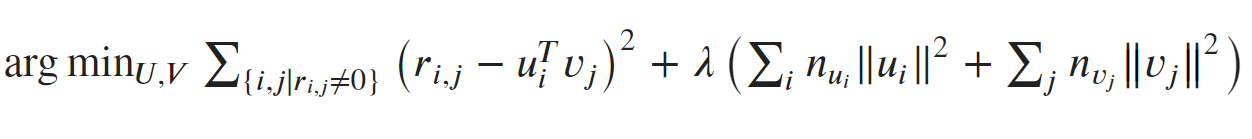

In [65]:
# Some of the most important hyperparameters for the ALS model are:
# `factors`: The number of latent factors to use for the underlying model
# `regularization` (lambda from the formula above): Strength of regularization
# `iterations`: The number of ALS iterations to use when fitting data

In [66]:
def validate_ALS(X_train_csr,
                 X_val_csr,
                 factors=64,
                 iterations=15,
                 regularization=0.01,
                 show_progress=True,
                 show_params=True):
    """
    Define an AlternatingLeastSquares model with the given hyperparameters
    Then, fit the model and validate the model, computing the MAP@K metric
    MAP@K details:https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
    
    @param `X_train_csr`: CSR matrix used for fitting the model
    @param `X_val_csr`: CSR matrix used for validating the model
    @param `factors`: The number of latent factors to compute
    @param `iterations`: The number of ALS iterations to use when fitting data
    @param `regularization`: The regularization factor to use
    @param `show_progress`: Print or suppress the progress of fitting/validating the model
    @param `show_params`: Print or suppress the current hyperparameters of the model
    @return: The computed MAP@K metric
    """

    # Define the model with the given hyperparameters
    als = AlternatingLeastSquares(factors=factors,
                                  iterations=iterations,
                                  regularization=regularization,
                                  use_gpu=True,
                                  random_state=RANDOM_STATE)
    
    # In the previous versions (version < 0.5.0), ALS required a
    # CSR/COO matrix of type (items x users) for training the model
    if implicit.__version__ < '0.5.0':
        X_train_csr = X_train_csr.T
    
    # Fit the model with the training data
    als.fit(X_train_csr, show_progress=show_progress)
    
    # A common metric for validating the model is `MAP@K`
    # We can also try the `Cosine similarity` metric
    K = 10 # Number of items to test on
    map_res = mean_average_precision_at_k(als,
                                          X_train_csr,
                                          X_val_csr,
                                          K,
                                          show_progress=show_progress)
    
    if show_params:
        print(f'Factors: {factors}\t |             \
              Iterations: {iterations}\t |         \
              Regularization: {regularization}\t | \
              MAP@{K}: {map_res}')
        
    return map_res

### Learning curves

In [67]:
def learning_curves(model, data, show_progress=False):
    """
    Fit and validate the model using different proportions
    of the dataset for training and validating respectively
    
    @param `model`: ALS model
    @param `data`: Dataframe with mandatory `t_dat`, `user_id` and `item_id` columns
    @param `show_progress`:
    @return: List of MAP@K (floats) results for each values of `val_days`
    """
    
    mapk = []
    for val_days in range(21, 6, -1):
        X_train_csr, X_val_csr = get_users_items_matrices(data, validation_days=val_days)
        model.fit(X_train_csr, show_progress=show_progress)
        curr_mapk = mean_average_precision_at_k(als, X_train_csr, X_val_csr, show_progress=show_progress)
        mapk.append(curr_mapk)
        val_set_frac = round((val_days / 30) * 100, 2)
        print(f'Train: {(100 - val_set_frac):.2f}% | Validation: {val_set_frac:.2f}% | MAP@K: {curr_mapk:.5f}')
    
    return mapk

In [68]:
mapk = learning_curves(als, transactions)

Train: 30.00% | Validation: 70.00% | MAP@K: 0.00194
Train: 33.33% | Validation: 66.67% | MAP@K: 0.00214
Train: 36.67% | Validation: 63.33% | MAP@K: 0.00214
Train: 40.00% | Validation: 60.00% | MAP@K: 0.00231
Train: 43.33% | Validation: 56.67% | MAP@K: 0.00243
Train: 46.67% | Validation: 53.33% | MAP@K: 0.00261
Train: 50.00% | Validation: 50.00% | MAP@K: 0.00282
Train: 53.33% | Validation: 46.67% | MAP@K: 0.00299
Train: 56.67% | Validation: 43.33% | MAP@K: 0.00316
Train: 60.00% | Validation: 40.00% | MAP@K: 0.00334
Train: 63.33% | Validation: 36.67% | MAP@K: 0.00355
Train: 66.67% | Validation: 33.33% | MAP@K: 0.00388
Train: 70.00% | Validation: 30.00% | MAP@K: 0.00416
Train: 73.33% | Validation: 26.67% | MAP@K: 0.00427
Train: 76.67% | Validation: 23.33% | MAP@K: 0.00441


Text(0, 0.5, 'MAP@K')

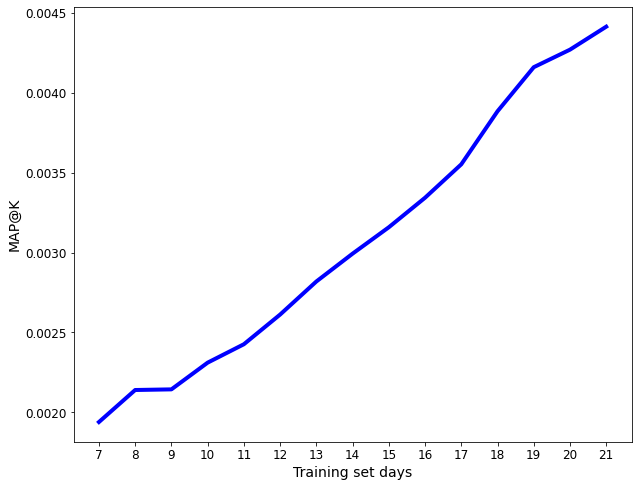

In [69]:
# Plot the results
plt.figure(figsize=(10, 8))
plt.xticks(range(7, 22))
plt.plot(range(7, 22), mapk, "b-", linewidth=4)
plt.xlabel("Training set days", fontsize=14)
plt.ylabel("MAP@K", fontsize=14)

In [70]:
%%time
map_res = validate_ALS(X_train_csr, X_val_csr)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/75481 [00:00<?, ?it/s]

Factors: 64	 |                           Iterations: 15	 |                       Regularization: 0.01	 |               MAP@10: 0.0044062961150783874
CPU times: user 989 ms, sys: 28 ms, total: 1.02 s
Wall time: 1.01 s


## Tuning hyperparameters

In [71]:
# I will use this class from `sklearn` to generate a `params_search_space`
# used for computing a manual grid search
from sklearn.model_selection import ParameterGrid
search_space = {
    'factors': [50, 75, 100, 125, 150, 175, 225, 250],
    'iterations': [5, 10, 15, 20],
    'regularization': [0.005, 0.01, 0.05]
}
param_grid = list(ParameterGrid(search_space))

In [72]:
# len(param_grid) = len(factors) * len(iterations) * len(regularization)
len(param_grid)

96

In [73]:
param_grid[0]

{'factors': 50, 'iterations': 5, 'regularization': 0.005}

In [74]:
param_grid[len(param_grid) - 1]

{'factors': 250, 'iterations': 20, 'regularization': 0.05}

In [75]:
%%time
# Perfect, now we can find the best hyperparameters for our ALS model
# I will not run this in the final version of the notebook, because it takes quite a while

curr_map = -1
best_map = -1
best_params = {}
for params in param_grid:
    # Compute the current MAP value
#     curr_map = validate_ALS(X_train_csr,
#                             X_val_csr,
#                             factors=params['factors'],
#                             iterations=params['iterations'],
#                             regularization=params['regularization'])
    
    # Update `best_*` if found better score
    if curr_map > best_map:
        best_map    = curr_map
        best_params = params 
        print(f'Best score until now: {best_map} | Updating: {best_params}')

CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 17.6 µs


In [76]:
# After doing a little research, I've found that a good set of hyperparameters
# for this model & dataset are: {'factors': 300, 'iterations': 5, 'regularization': 0.01}
best_params = {
    'factors': 300,
    'iterations': 5,
    'regularization': 0.01
}

# We can train the model with those parameters
best_model = AlternatingLeastSquares(factors=best_params['factors'],
                                     iterations=best_params['iterations'],
                                     regularization=best_params['regularization'],
                                     use_gpu=True,
                                     random_state=RANDOM_STATE)
    
# Now, we can train the model on the entire training data (last month of transactions)
X_train_full_csr = users_items_csr(transactions)
best_model.fit(X_train_full_csr)

  0%|          | 0/5 [00:00<?, ?it/s]

## Generate submission file

In [77]:
# This version of code works well if the `implicit` package is v0.5.0 or greater
# It's much much faster when passing an array of user_ids instead of a single user_id,
# because it allows multi-thread processing: https://github.com/benfred/implicit/pull/520
def recommend(model, csr_train, batch_size=1000):
    """
    Recommend items for all customers and generate the submission df
    
    @param `model`: Fitted ALS model used for recommendations
    @param `csr_train`: Matrix used for training the model
    @param `batch_size`: Size of each batch used for predictions
    """
    
    # List of tuples of type (customer_id, [recommended_article_ids])
    predictions = []
    
    # List starting from 0 to len(users_list) with step 1
    list_ids = np.arange(len(users_list))

    # For each batch
    for idx in range(0, len(list_ids), batch_size):
        # Select the current batch of users
        batch = list_ids[idx : (idx + batch_size)]

        # Recommend to those specific users in the current batch
        ids, scores = model.recommend(batch, csr_train[batch])
        
        # For each user in the batch
        for curr_user_idx, user_id in enumerate(batch):
            # Convert from `user_id` to the original `customer_id` format,
            # using the 1:1 mapping created earlier
            customer_id = users_list[user_id]
            
            # Get the recommended items for this specific user
            user_items = ids[curr_user_idx]
            
            # Convert from `item_id` to the original `article_id` format,
            # creating a list of `article_ids`
            article_ids = [items_list[item_id] for item_id in user_items]
            
            # Append the tuple (user, recommended_items)
            predictions.append((customer_id, '0' + ' '.join(article_ids)))

    # Generate the pd df
    return pd.DataFrame(predictions, columns=['customer_id', 'prediction'])

In [78]:
%%time
pred_df = recommend(best_model, X_train_full_csr)

CPU times: user 20.9 s, sys: 177 ms, total: 21.1 s
Wall time: 21.5 s


In [79]:
pred_df.to_csv('submission_alg2.csv', index=False)